In [2]:
import pandas as pd 
import numpy as np
import nltk
import re 
import os 
import random 
import matplotlib.pyplot as plt
import seaborn as sns 
from io import StringIO
from nltk.corpus import stopwords
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import chardet

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
with open('/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv', 'rb') as f:
    raw_data = f.read(100000)

result = chardet.detect(raw_data)
print(result['encoding'],', confidence: ', result['confidence'] )

utf-8 , confidence:  0.99


In [6]:
with open('/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv', 
          'r', encoding= 'utf-8', errors='replace') as f:
    raw_text = f.read()  

df = pd.read_csv(StringIO(raw_text))
df.head(5)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


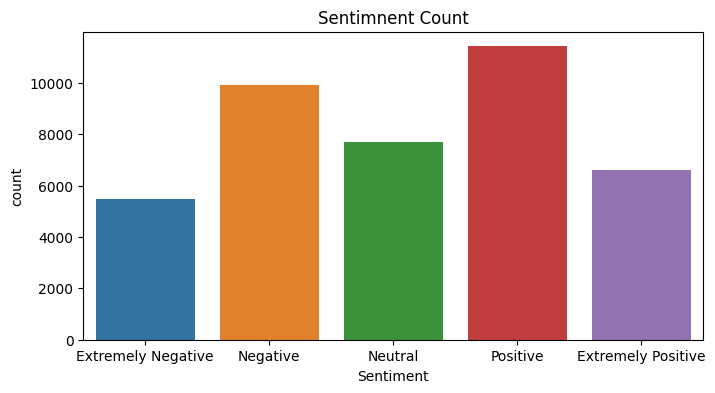

In [7]:
clean_df = df.copy()
clean_df = clean_df[~clean_df.map(lambda x: isinstance(x, str) and '�' in x).any(axis=1)]
plt.figure(figsize = (8, 4))
sns.countplot(x = 'Sentiment',  data = clean_df, 
              order = ['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive'])
plt.title("Sentimnent Count")
plt.show()

<font size = "3">
긍정이 조금 더 많긴 하나, 대칭적인 분포를 보인다.

-----

NLP의 전처리 단계는

1. Stop word (불용어) 제거
2. 영어의 경우 소문자화 lowercase 해주기
3. stemming을 통해 어원 추출
4. Tokenization을 통해 숫자로 바꿔주기

In [8]:
def convert_sentiment(x):
    if x == 'Extremely Positive':
        x = 2
    elif x == 'Positive':
        x = 2
    elif x == 'Neutral':
        x = 1
    elif x == 'Negative':
        x = 0
    else:
        x = 0
    return x


def preprocess_text(x):
    x = re.sub(r'@\S*', "", x)
    x = re.sub(r'https?:\/\/\S*', "", x)
    x = re.sub(r'#\S*', "", x)
    x = re.sub('\n', "", x)
    x = re.sub('', "'", x)
    x = x.lower()
    return x.strip()


preprocess_df = clean_df.copy()
preprocess_df['Sentiment'] = preprocess_df['Sentiment'].apply(convert_sentiment)
preprocess_df['OriginalTweet'] = preprocess_df['OriginalTweet'].apply(preprocess_text)
preprocess_df.drop(columns = ['UserName', 'ScreenName','Location', 'TweetAt'], inplace = True)
preprocess_df = preprocess_df[preprocess_df['OriginalTweet'].str.split().str.len() > 5]
preprocess_df.reset_index(drop = True, inplace = True)


preprocess_df['OriginalTweet'].str.len().describe()

count    40289.000000
mean       161.741120
std         65.986932
min         19.000000
25%        105.000000
50%        167.000000
75%        218.000000
max        306.000000
Name: OriginalTweet, dtype: float64

In [10]:
preprocess_df.sample(10)

,OriginalTweet,Sentiment
12779,wake up to a new realityhappy to get eggs and ...,0
32070,but why bail out juniors that are already fail...,0
4800,"it's real shame that the so called ""hindustan""...",0
5584,the church of jesus christ of latter-day saint...,1
16828,i m bidding up prices on other states says r...,2
28433,?free review and immediate budget??the best fi...,2
18701,golden boys proved to be the most useless grou...,0
36158,do you really need that toilet paper?,1
11836,covid 19 x climate crisis food insecurity thre...,0
17062,price gouging in a state of emergency is illeg...,0


In [12]:
class TweetDataset(Dataset):
    def __init__(self, tokens, labels):
        self.tokens = {key: torch.tensor(val) for key, val in tokens.items()}
        self.labels = torch.LongTensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.tokens.items()}
        item['labels'] = self.labels[idx]
        return item



train_texts, val_texts, train_labels, val_labels = train_test_split(
    preprocess_df['OriginalTweet'].tolist(), preprocess_df['Sentiment'].tolist(),
    test_size = 0.2, random_state = 42
)



base_model = "bert-base-uncased"
bert_tokenizer = BertTokenizer.from_pretrained(base_model)
train_tokenized = bert_tokenizer(train_texts, truncation=True, padding=True, max_length=184)
val_tokenized = bert_tokenizer(val_texts, truncation=True, padding=True, max_length=184)


train_dataset = TweetDataset(train_tokenized, train_labels)
val_dataset = TweetDataset(val_tokenized, val_labels)


device=  torch.device("cuda" if torch.cuda.is_available() else 'cpu')
bert_model = BertForSequenceClassification.from_pretrained(base_model, num_labels = 3)
bert_model.to(device)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [13]:
training_args = TrainingArguments(
    output_dir = "./results",
    num_train_epochs = 3,
    per_device_train_batch_size = 32,
    per_device_eval_batch_size = 32,
    warmup_steps = 500,
    weight_decay = 0.01,
    logging_dir = './logs',
    logging_steps = 200,
    eval_strategy = 'epoch',
    save_strategy = 'epoch',
    report_to = "none",
    fp16 = True,
)

trainer = Trainer(
    model = bert_model,
    args= training_args,
    train_dataset = train_dataset,
    eval_dataset = val_dataset
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.566100,0.376634
2,0.237700,0.241339
3,0.133600,0.230574


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=1512, training_loss=0.3631836081308032, metrics={'train_runtime': 1762.8956, 'train_samples_per_second': 54.849, 'train_steps_per_second': 0.858, 'total_flos': 9142940486071728.0, 'train_loss': 0.3631836081308032, 'epoch': 3.0})

In [16]:
def predict_sentiment(text):
    inputs = bert_tokenizer(text, return_tensors = "pt", truncation = True, padding = True,
                           max_length = 184)
    inputs = {key : val.to(device)  for key, val in inputs.items()}
    
    with torch.no_grad():
        outputs = bert_model(**inputs)
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim= 1).item()
    
    return predicted_class



In [23]:
with open('/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv',
          'r', encoding ='utf-8' , errors = 'replace') as f:
    raw_data = f.read()


test_df = pd.read_csv(StringIO(raw_data))




    
clean_df = test_df.copy()
clean_df = clean_df[~clean_df.map(lambda x: isinstance(x, str) and '�' in x).any(axis=1)]
preprocess_df = clean_df.copy()
preprocess_df['Sentiment'] = preprocess_df['Sentiment'].apply(convert_sentiment)
preprocess_df['OriginalTweet'] = preprocess_df['OriginalTweet'].apply(preprocess_text)
preprocess_df.drop(columns = ['UserName', 'ScreenName','Location', 'TweetAt'], inplace = True)
preprocess_df = preprocess_df[preprocess_df['OriginalTweet'].str.split().str.len() > 5]
preprocess_df.reset_index(drop = True, inplace = True)

In [26]:
from sklearn.metrics import accuracy_score

test_texts = preprocess_df["OriginalTweet"].tolist()
true_labels = preprocess_df["Sentiment"].tolist()
predicted_labels = [predict_sentiment(text) for text in test_texts]


accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Test Accuracy: {accuracy:.4f}")


Test Accuracy: 0.9243


테스트셋의 정확도가 92.43%가량으로 꽤나 정확한 편. 

---------------------------------------------------
### Word2Vec 

In [1]:
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
import gensim.downloader as api
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import pandas as pd 
import numpy as np
import nltk
import re 
import os 
import random 
import matplotlib.pyplot as plt
import seaborn as sns 
from io import StringIO
from nltk.corpus import stopwords
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
import torch
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import chardet

In [2]:
def convert_sentiment(x):
    if x == 'Extremely Positive':
        x = 2
    elif x == 'Positive':
        x = 2
    elif x == 'Neutral':
        x = 1
    elif x == 'Negative':
        x = 0
    else:
        x = 0
    return x


def preprocess_text(x):
    x = re.sub(r'@\S*', "", x)
    x = re.sub(r'https?:\/\/\S*', "", x)
    x = re.sub(r'#\S*', "", x)
    x = re.sub('\n', "", x)
    x = re.sub('', "'", x)
    x = x.lower()
    return x.strip()

In [3]:
with open('/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv', 
          'r', encoding= 'utf-8', errors='replace') as f:
    raw_text = f.read()  

df = pd.read_csv(StringIO(raw_text))

clean_df = df.copy()
clean_df = clean_df[~clean_df.map(lambda x: isinstance(x, str) and '�' in x).any(axis=1)]
preprocess_df = clean_df.copy()
preprocess_df['Sentiment'] = preprocess_df['Sentiment'].apply(convert_sentiment)
preprocess_df['OriginalTweet'] = preprocess_df['OriginalTweet'].apply(preprocess_text)
preprocess_df.drop(columns = ['UserName', 'ScreenName','Location', 'TweetAt'], inplace = True)
preprocess_df = preprocess_df[preprocess_df['OriginalTweet'].str.split().str.len() > 5]
preprocess_df.reset_index(drop = True, inplace = True)
preprocess_df.head(5)

,OriginalTweet,Sentiment
0,advice talk to your neighbours family to excha...,2
1,coronavirus australia: woolworths to give elde...,2
2,my food stock is not the only one which is emp...,2
3,"me, ready to go at supermarket during the out...",0
4,as news of the region's first confirmed covid-...,2


In [4]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(preprocess_df['OriginalTweet'])
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

sequences = tokenizer.texts_to_sequences(preprocess_df['OriginalTweet'])
MAX_SEQUENCE_LENGTH = max([len(seq) for seq in sequences])

padded_sequences = pad_sequences(sequences, maxlen = MAX_SEQUENCE_LENGTH, padding = 'post')
labels = np.array(preprocess_df['Sentiment'])


In [5]:
# 방법 1: LSTM모델에서 임베딩

lstm_model = Sequential([
    Embedding(input_dim = vocab_size, output_dim = 100, input_length = MAX_SEQUENCE_LENGTH),
    LSTM(128, return_sequences = True),
    Dropout(0.5),
    LSTM(64),
    Dropout(0.5),
    Dense(32, activation = 'relu'),
    Dense(3, activation = 'softmax')
])

lstm_model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer ='adam',
    metrics = ['accuracy']
)



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [6]:
text_train, text_val, label_train, label_val = train_test_split(padded_sequences, labels,
                                                               test_size = 0.2, random_state = 42)

history = lstm_model.fit(
    text_train, label_train,
    validation_data = (text_val, label_val),
    epochs = 10,
    batch_size = 32,
    verbose = 1
)

Epoch 1/10
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.4703 - loss: 0.9876 - val_accuracy: 0.6519 - val_loss: 0.8256
Epoch 2/10
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.7050 - loss: 0.7366 - val_accuracy: 0.7695 - val_loss: 0.6211
Epoch 3/10
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8136 - loss: 0.5099 - val_accuracy: 0.8328 - val_loss: 0.4835
Epoch 4/10
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8964 - loss: 0.3249 - val_accuracy: 0.8657 - val_loss: 0.3962
Epoch 5/10
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9305 - loss: 0.2291 - val_accuracy: 0.8614 - val_loss: 0.4047
Epoch 6/10
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9481 - loss: 0.1692 - val_accuracy: 0.8725 - val_loss: 0.4222
Epoch 7/10
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9597 - loss: 0.1300 - val_accuracy: 0.8733 - val_loss: 0.4768
Epoch 8/10
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9677 -

LSTM 베이스 모델은 대략 val Accuracy가 86% 정도. 이번엔 임베딩 방식을 사전학습된 word2vec으로 해보자

In [24]:
from gensim.models import KeyedVectors

# 1️⃣ `.model` 파일 경로 설정 (이미 /kaggle/working/ 에 복사됨)
model_dest = "/kaggle/working/word2vec-google-news-300.model"

# 2️⃣ KeyedVectors로 모델 로드 (Word2Vec.load() 대신 사용!)
word2vec_model = KeyedVectors.load(model_dest)


[ 1.25976562e-01  2.97851562e-02  8.60595703e-03  1.39648438e-01
 -2.56347656e-02 -3.61328125e-02  1.11816406e-01 -1.98242188e-01
  5.12695312e-02  3.63281250e-01 -2.42187500e-01 -3.02734375e-01
 -1.77734375e-01 -2.49023438e-02 -1.67968750e-01 -1.69921875e-01
  3.46679688e-02  5.21850586e-03  4.63867188e-02  1.28906250e-01
  1.36718750e-01  1.12792969e-01  5.95703125e-02  1.36718750e-01
  1.01074219e-01 -1.76757812e-01 -2.51953125e-01  5.98144531e-02
  3.41796875e-01 -3.11279297e-02  1.04492188e-01  6.17675781e-02
  1.24511719e-01  4.00390625e-01 -3.22265625e-01  8.39843750e-02
  3.90625000e-02  5.85937500e-03  7.03125000e-02  1.72851562e-01
  1.38671875e-01 -2.31445312e-01  2.83203125e-01  1.42578125e-01
  3.41796875e-01 -2.39257812e-02 -1.09863281e-01  3.32031250e-02
 -5.46875000e-02  1.53198242e-02 -1.62109375e-01  1.58203125e-01
 -2.59765625e-01  2.01416016e-02 -1.63085938e-01  1.35803223e-03
 -1.44531250e-01 -5.68847656e-02  4.29687500e-02 -2.46582031e-02
  1.85546875e-01  4.47265

In [29]:
# 방법2: word2vec으로 임베딩




toeknizer = Tokenizer()
tokenizer.fit_on_texts(preprocess_df['OriginalTweet'])
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1


embedding_dim = 300

embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    if word in word2vec_model:
        embedding_matrix[i] = word2vec_model[word]

embedding_layer = Embedding(input_dim = vocab_size, output_dim = embedding_dim,
                           weights = [embedding_matrix], input_length = MAX_SEQUENCE_LENGTH,
                           trainable = False)

model = Sequential([
    embedding_layer,
    LSTM(128, return_sequences = True),
    Dropout(0.5),
    LSTM(64),
    Dropout(0.5),
    Dense(32, activation = 'relu'),
    Dense(3, activation = 'softmax')
])

model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [30]:
sequences = tokenizer.texts_to_sequences(preprocess_df['OriginalTweet'])
MAX_SEQUENCE_LENGTH = max([len(seq) for seq in sequences])

padded_sequences = pad_sequences(sequences, maxlen = MAX_SEQUENCE_LENGTH, padding = 'post')
labels = np.array(preprocess_df['Sentiment'])


text_train, text_val, label_train, label_val = train_test_split(padded_sequences, labels,
                                                               test_size = 0.2, random_state = 42)

history = model.fit(
    text_train, label_train,
    validation_data = (text_val, label_val),
    epochs = 10,
    batch_size = 32,
    verbose = 1
)

Epoch 1/10
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.4662 - loss: 0.9793 - val_accuracy: 0.6790 - val_loss: 0.7776
Epoch 2/10
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.7025 - loss: 0.7426 - val_accuracy: 0.7585 - val_loss: 0.6159
Epoch 3/10
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.7896 - loss: 0.5709 - val_accuracy: 0.7981 - val_loss: 0.5469
Epoch 4/10
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8161 - loss: 0.5102 - val_accuracy: 0.8008 - val_loss: 0.5155
Epoch 5/10
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8268 - loss: 0.4691 - val_accuracy: 0.8253 - val_loss: 0.4890
Epoch 6/10
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8506 - loss: 0.4239 - val_accuracy: 0.8232 - val_loss: 0.4871
Epoch 7/10
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8592 - loss: 0.3966 - val_accuracy: 0.8361 - val_loss: 0.4437
Epoch 8/10
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8785 - loss: 0.3519 -

LSTM 모델에서 임베딩을 했을 땐 과적합되는 경향이 있었으나 (train 데이터 셋 정확도 96%, val셋 86%), pre_trained model에선 비교적 과적합되는 경향이 적다. 다만, val 정확도는 조금 더 낮은 편.